# PyPoT Example Code

This notebook includes example code for performing peaks-over-threshold analysis tasks using PyPoT.

## Simulate Generalized Pareto data and fit univariate model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypot.generalized_pareto import gp_inv_cdf, fit_GPD, gp_density

In [2]:
# true parameters
XI = -0.20
SIGMA = 0.75
# number of simulations
N_SIM = 10000

# uniform random samples
u = np.random.uniform(size=N_SIM)

# probability integral transform data into GPD samples
y = gp_inv_cdf(u, XI, SIGMA)

# DataFrame with y as column
data = pd.DataFrame(y, columns=["y"])

# fit univariate model to data
mle = fit_GPD(data, "y", [])

xi_hat = mle[0]

# reparameterize back to sigma
sigma_hat = np.exp(mle[1])

print("maximum likelihood estimates of xi, sigma:")
print(mle[0], sigma_hat)

maximum likelihood estimates of xi, sigma:
-0.2012563214980199 0.7468145036690725


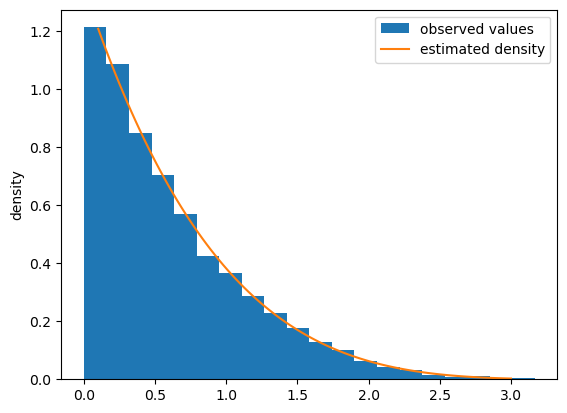

In [21]:
plt.hist(y, density=True, label="observed values", bins=20)

# MLE ESTIMATE
x_plot = np.linspace(0.1, 3, 100)
y_plot = gp_density(x_plot, mle[0], sigma_hat)
plt.plot(x_plot, y_plot, label="estimated density")
plt.ylabel("density", fontsize=10)
plt.legend()

plt.show()

## Compute confidence intervals for GP parameters

In [22]:
from pypot.generalized_pareto import gp_param_cov_matrix

In [24]:
# 90% asymptotic CI
Z_star = 1.96

# compute covariance matrix of estimators
estimator_cov_mat = gp_param_cov_matrix(xi_hat, sigma_hat, N_SIM)

confint_xi = [xi_hat - Z_star * np.sqrt(estimator_cov_mat[0][0]), xi_hat + Z_star * np.sqrt(estimator_cov_mat[0][0])]
print("confidence interval for xi:")
print(confint_xi)

confint_sigma = [sigma_hat - Z_star * np.sqrt(estimator_cov_mat[1][1]), sigma_hat + Z_star * np.sqrt(estimator_cov_mat[1][1])]
print("confidence interval for sigma:")
print(confint_sigma)


confidence interval for xi:
[-0.2099040193946098, -0.17142312616391148]
confidence interval for sigma:
[0.722445952226765, 0.7593979628654681]


## Load example time series dataset and automatically find threshold via ForwardStop algorithm

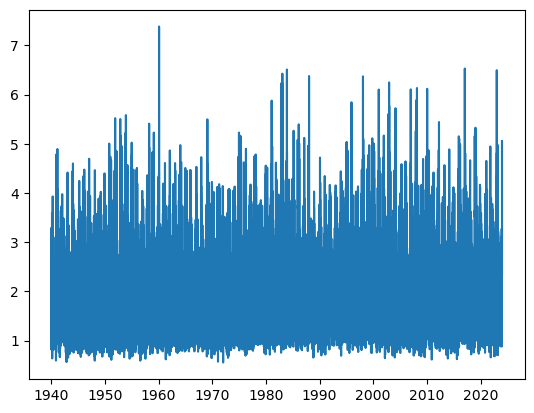

In [4]:
from pypot.utils import fetch_example_dataset, get_extremes_peaks_over_threshold

wave_data = fetch_example_dataset()

swell_heights = wave_data["swh"]
plt.plot(swell_heights.index, swell_heights)
plt.show()

In [6]:
from pypot.threshold_selection import forward_stop_u_selection

# set lower threshold bound at 99th quantile
lower = round(swell_heights.quantile(0.99), 2)
print("lower threshold search bound:")
print(lower)

# round down from max for upper bound
upper = round(swell_heights.quantile(0.999), 2)
upper = float(upper)
print("upper threshold search bound:")
print(upper)

# set number of thresholds to search
l = 10

selected_thresh, theta_hat = forward_stop_u_selection(
    wave_data,          # dataset
    "swh",     # column name of gpd series
    lower,              # lower bound for threshold
    upper,              # upper bound for threshold
    l,                  # number of thresholds to try
    "72h",              # independence time delta r
    alpha=0.05          # false discovery rate
)


print("selected threshold:")
print(selected_thresh)

print("mle at selected threshold:")
print(theta_hat)

lower threshold search bound:
3.85
upper threshold search bound:
5.01
selected threshold:
3.85
mle at selected threshold:
[-0.06438454  0.66576411]


## Compute return levels and confidence intervals for selected threshold

In [7]:
from pypot.utils import years_span_series
from pypot.return_levels import lambda_hat, r_hat, var_hat_r_l

# initial point for optimizer
u = selected_thresh

# independence definition
r = "72h"

extremes = get_extremes_peaks_over_threshold(
    swell_heights,
    selected_thresh,
    r
)

# Poisson process lambda MLE
l_hat = lambda_hat(extremes)
print("mle for lambda:")
print(l_hat)

mle for lambda:
4.109973504301462


In [8]:

# return period
L = 50

r_hat_50 = r_hat(L, l_hat, xi_hat, sigma_hat)
print(f"estimated {L} year return value:")
# add back the subtracted threshold
print(r_hat_50 + u)

# sample size
n = len(extremes)
# time spanned by the series in years
t = years_span_series(swell_heights)
print("sample size:")
print(n)
print("years span:")
print(t)

# asymptotic variance of 50 year return value
var_L = var_hat_r_l(l_hat, xi_hat, sigma_hat, n, t, L)

sd = np.sqrt(var_L)

print(f"{L} year return variance:")
print(var_L)
print(f"{L} year standard deviation")
print(sd)

# compute 90% confidence interval
Z_SCORE = 1.645

lower_bound = u + r_hat_50 -  Z_SCORE * sd
upper_bound = u + r_hat_50 + Z_SCORE * sd

print(f"{L} year return value:")
print(u + r_hat_50)

print("90% CI:")
print(lower_bound)
print(upper_bound)


estimated 50 year return value:
6.290201213977557
sample size:
344
years span:
83.99726214921287
50 year return variance:
[[0.04720886]]
50 year standard deviation
[[0.21727601]]
50 year return value:
6.290201213977557
90% CI:
[[5.93278218]]
[[6.64762025]]


## Fit multivariate model

TODO!